In [1]:
import pandas as pd
from ta import add_all_ta_features
from ta.utils import dropna
import yfinance as yf
import matplotlib as plt
import numpy as np

df = yf.download('^RUA', start='2002-01-01', end='2021-12-31', progress=False)
df.reset_index("Date", inplace=True) #resetting index

#df = dropna(df)

#Add ta features filling NaN values
df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume",fillna=True)
df=df.dropna()

#data for 2003-2021
df1 = yf.download('^RUA', start='2003-01-01', end='2021-12-31', progress=False)
df1.reset_index("Date", inplace=True) #resetting index
df1 = add_all_ta_features(df1, open="Open", high="High", low="Low", close="Close", volume="Volume",fillna=True)
df1=df1.dropna()

C:\Users\lemon\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\lemon\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [2]:
df = pd.DataFrame(df)
list(df.columns)

['Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'volume_adi',
 'volume_obv',
 'volume_cmf',
 'volume_fi',
 'volume_em',
 'volume_sma_em',
 'volume_vpt',
 'volume_vwap',
 'volume_mfi',
 'volume_nvi',
 'volatility_bbm',
 'volatility_bbh',
 'volatility_bbl',
 'volatility_bbw',
 'volatility_bbp',
 'volatility_bbhi',
 'volatility_bbli',
 'volatility_kcc',
 'volatility_kch',
 'volatility_kcl',
 'volatility_kcw',
 'volatility_kcp',
 'volatility_kchi',
 'volatility_kcli',
 'volatility_dcl',
 'volatility_dch',
 'volatility_dcm',
 'volatility_dcw',
 'volatility_dcp',
 'volatility_atr',
 'volatility_ui',
 'trend_macd',
 'trend_macd_signal',
 'trend_macd_diff',
 'trend_sma_fast',
 'trend_sma_slow',
 'trend_ema_fast',
 'trend_ema_slow',
 'trend_vortex_ind_pos',
 'trend_vortex_ind_neg',
 'trend_vortex_ind_diff',
 'trend_trix',
 'trend_mass_index',
 'trend_dpo',
 'trend_kst',
 'trend_kst_sig',
 'trend_kst_diff',
 'trend_ichimoku_conv',
 'trend_ichimoku_base',
 'trend_ichimoku_a

# Trend indicators: lagging

In [3]:
from ta.trend import macd
#df["macd"] = macd(df.Close, window_slow = 26, window_fast = 12)

#df["trend_macd_signal"]

from ta.trend import ema_indicator
df["EMA10"]= ema_indicator(df.Close, window=10)
#df["EMA12"]= ema_indicator(df.Close, window=14)
#df["EMA50"]= ema_indicator(df.Close, window=50)
df["EMA100"]= ema_indicator(df.Close, window=100)
#df["EMA200"]= ema_indicator(df.Close, window=200)
df1["EMA10"]= ema_indicator(df1.Close, window=10)
df1["EMA100"]= ema_indicator(df1.Close, window=100)
#df1["EMA10"]= ema_indicator(df1.Close, window=10)
#df1["EMA20"]= ema_indicator(df1.Close, window=100)
#df["EMA50"]= ema_indicator(df1.Close, window=100)
#df["EMA200"]= ema_indicator(df1.Close, window=200)

from ta.trend import sma_indicator
#df["SMA10"]= sma_indicator(df.Close, window=10)
#df["SMA50"]= sma_indicator(df.Close, window=50)
#df["SMA100"]= sma_indicator(df.Close, window=100)

# Momentum indicators: leading

# Volatility indicators: lagging

# Strategy

# 1. Only Trend

In [4]:
#Strategy 1: 10EMA & 100EMA, golden cross
#status: 0-->1:(1)bull, 1-->0:(-1) bear, o/w(0): neutral

In [5]:
strat1=df[["Date","EMA10","EMA100"]]
strat1=strat1.dropna()
strat1 = strat1.drop(labels=range(99, 251), axis=0)

In [6]:
strat1["golden_cross_signal"] = strat1.apply(lambda row: 1 if row[f"EMA10"] > row[f"EMA100"]  else 0, axis=1)
#lambda x: x*10 if x<2 else (x**2 if x<4 else x+10)

# Generate market regime
#0-->1:(1)bull, 1-->0:(-1) bear, o/w: neutral
strat1['state'] = strat1['golden_cross_signal'].diff()
strat1 = strat1.drop(labels=range(251, 252), axis=0)
#reset index
strat1=strat1.reset_index()
strat1=strat1.drop(columns=['index'])

strat1

,Date,EMA10,EMA100,golden_cross_signal,state
0,2003-01-02,495.928213,503.591429,0,0.0
1,2003-01-03,497.535809,503.614767,0,0.0
2,2003-01-06,500.900203,503.860810,0,0.0
3,2003-01-07,503.000168,504.030894,0,0.0
4,2003-01-08,503.420137,504.056222,0,0.0
...,...,...,...,...,...
4749,2021-12-23,2730.984040,2676.300265,1,0.0
4750,2021-12-27,2744.212394,2678.823824,1,0.0
4751,2021-12-28,2754.055613,2681.190680,1,0.0
4752,2021-12-29,2762.749159,2683.580372,1,0.0


In [7]:
strat1['state'].value_counts()

 0.0    4685
 1.0      35
-1.0      34
Name: state, dtype: int64

# 2 Trend + Momentum

In [8]:
#Strategy 2: trend+momentum, 100EMA + RSI
#status: (1)bull, (-1)bear, o/w(0): neutral
strat2=df[["Date","EMA100","momentum_rsi","Close"]]
strat2=strat2.dropna()
strat2 = strat2.drop(labels=range(99, 252), axis=0)

In [9]:
conditions = [(strat2['Close'] > strat2['EMA100']) & (strat2['momentum_rsi'] > 50),
    (strat2['Close'] < strat2['EMA100']) & (strat2['momentum_rsi'] < 50)]

# create a list of the values we want to assign for each condition
values = ['-1', '1']

# create a new column and use np.select to assign values to it using our lists as arguments
strat2['state'] = np.select(conditions, values)
#reset index
strat2=strat2.reset_index()
strat2=strat2.drop(columns=['index'])

# display updated DataFrame
strat2['state'].value_counts()

-1    3009
1      908
0      837
Name: state, dtype: int64

In [10]:
strat2

,Date,EMA100,momentum_rsi,Close,state
0,2003-01-02,503.591429,54.839947,505.179993,-1
1,2003-01-03,503.614767,54.520771,504.769989,-1
2,2003-01-06,503.860810,61.204719,516.039978,-1
3,2003-01-07,504.030894,58.267104,512.450012,-1
4,2003-01-08,504.056222,52.835486,505.309998,-1
...,...,...,...,...,...
4749,2021-12-23,2676.300265,55.721696,2768.360107,-1
4750,2021-12-27,2678.823824,59.777151,2803.739990,-1
4751,2021-12-28,2681.190680,58.892209,2798.350098,-1
4752,2021-12-29,2683.580372,59.315808,2801.870117,-1


In [11]:
#Strategy 6: trend+momentum, ADX + Stochastic oscillator
#status: (1)bull, (-1)bear, (0)neutral
strat6=df1[["Date","trend_adx_pos","trend_adx_neg","momentum_stoch","Close"]]
strat6=strat6.dropna()
strat6

,Date,trend_adx_pos,trend_adx_neg,momentum_stoch,Close
0,2003-01-02,0.000000,0.000000,100.000000,505.179993
1,2003-01-03,0.000000,0.000000,91.278255,504.769989
2,2003-01-06,0.000000,0.000000,94.685987,516.039978
3,2003-01-07,0.000000,0.000000,81.882989,512.450012
4,2003-01-08,0.000000,0.000000,56.419348,505.309998
...,...,...,...,...,...
4749,2021-12-23,24.389816,23.795620,93.565473,2768.360107
4750,2021-12-27,27.787609,22.251320,99.910112,2803.739990
4751,2021-12-28,28.688912,21.495082,90.782641,2798.350098
4752,2021-12-29,27.806098,21.597449,92.911598,2801.870117


In [12]:
strat6["cross1"] = strat6.apply(lambda row: 1 if row[f"trend_adx_pos"] >= row[f"trend_adx_neg"] else 0, axis=1)
strat6["cross2"] = strat6.apply(lambda row: 1 if row[f"momentum_stoch"] >=30 else -1 if row[f"momentum_stoch"] <=70 else 0, axis=1)
# Generate market regime
#0-->1:(1)bull, 1-->0:(-1) bear, o/w: neutral
strat6['cond1'] = strat6['cross1'].diff()
strat6['cond2'] = strat6['cross2'].diff()
#Combined
strat6["cond"]= strat6["cond1"]+strat6["cond2"]
#State
strat6["state"] = strat6.apply(lambda row: 1 if row[f"cond"] > 1  else -1 if row[f"cond"] < -1 else 0, axis=1)
strat6['state'].value_counts()

 0    4158
-1     299
 1     297
Name: state, dtype: int64

In [13]:
strat6

,Date,trend_adx_pos,trend_adx_neg,momentum_stoch,Close,cross1,cross2,cond1,cond2,cond,state
0,2003-01-02,0.000000,0.000000,100.000000,505.179993,1,1,NaN,NaN,NaN,0
1,2003-01-03,0.000000,0.000000,91.278255,504.769989,1,1,0.0,0.0,0.0,0
2,2003-01-06,0.000000,0.000000,94.685987,516.039978,1,1,0.0,0.0,0.0,0
3,2003-01-07,0.000000,0.000000,81.882989,512.450012,1,1,0.0,0.0,0.0,0
4,2003-01-08,0.000000,0.000000,56.419348,505.309998,1,1,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
4749,2021-12-23,24.389816,23.795620,93.565473,2768.360107,1,1,1.0,0.0,1.0,0
4750,2021-12-27,27.787609,22.251320,99.910112,2803.739990,1,1,0.0,0.0,0.0,0
4751,2021-12-28,28.688912,21.495082,90.782641,2798.350098,1,1,0.0,0.0,0.0,0
4752,2021-12-29,27.806098,21.597449,92.911598,2801.870117,1,1,0.0,0.0,0.0,0


In [14]:
#Strategy 4: Trend+Momentum, 200EMA + Stochastic
#status: (1)bull, (-1)bear, (0)neutral
#strat4=df[["Date","EMA200","momentum_stoch","Close"]]
#strat4=strat4.dropna()
#strat4
#strat4[["momentum_stoch"]].plot(figsize=(20,10), grid=True)

# 3 Momentum + Volatility

In [15]:
#Strategy 3: RSI + BB, Momentum + Volatility
#status: (1)bull, (-1)bear, o/w(0): neutral
strat3=df1[["Date","volatility_bbh","volatility_bbl","momentum_rsi","Close"]]
strat3=strat3.dropna()
strat3

,Date,volatility_bbh,volatility_bbl,momentum_rsi,Close
0,2003-01-02,505.179993,505.179993,100.000000,505.179993
1,2003-01-03,505.384995,504.564987,0.000000,504.769989
2,2003-01-06,519.100860,498.225780,96.732235,516.039978
3,2003-01-07,519.225655,499.994331,72.630773,512.450012
4,2003-01-08,518.012949,499.487039,47.357769,505.309998
...,...,...,...,...,...
4749,2021-12-23,2786.561838,2648.870169,55.721696,2768.360107
4750,2021-12-27,2800.638241,2644.194767,59.777151,2803.739990
4751,2021-12-28,2810.062637,2640.626377,58.892209,2798.350098
4752,2021-12-29,2820.021515,2642.300506,59.315808,2801.870117


In [16]:
conditions = [(strat3['Close'] <= strat3['volatility_bbl']) & (strat3['momentum_rsi'] <= 30),
    (strat3['Close'] >= strat3['volatility_bbh']) & (strat3['momentum_rsi'] >= 70)]

# create a list of the values we want to assign for each condition
values = ['1', '-1']

# create a new column and use np.select to assign values to it using our lists as arguments
strat3['state'] = np.select(conditions, values)

# display updated DataFrame
strat3['state'].value_counts()

0     4624
-1      77
1       53
Name: state, dtype: int64

In [17]:
#Strategy 5: momentum+ volatility, RSI + BBp%
#status: (1)bull, (-1)bear, (0)neutral
strat5=df1[["Date","volatility_bbp","momentum_rsi","Close"]]
strat5=strat5.dropna()
conditions = [(strat5['momentum_rsi'] < 30) & (strat5['volatility_bbp'] < 0),
    (strat5['momentum_rsi'] > 70) & (strat5['volatility_bbp'] > 1)]

# create a list of the values we want to assign for each condition
values = ['1', '-1']

# create a new column and use np.select to assign values to it using our lists as arguments
strat5['state'] = np.select(conditions, values)
strat5['state'].value_counts()

0     4625
-1      76
1       53
Name: state, dtype: int64

In [18]:
strat5

,Date,volatility_bbp,momentum_rsi,Close,state
0,2003-01-02,0.000000,100.000000,505.179993,0
1,2003-01-03,0.250000,0.000000,504.769989,0
2,2003-01-06,0.853371,96.732235,516.039978,0
3,2003-01-07,0.647677,72.630773,512.450012,0
4,2003-01-08,0.314314,47.357769,505.309998,0
...,...,...,...,...,...
4749,2021-12-23,0.867808,55.721696,2768.360107,0
4750,2021-12-27,1.019827,59.777151,2803.739990,0
4751,2021-12-28,0.930873,58.892209,2798.350098,0
4752,2021-12-29,0.897866,59.315808,2801.870117,0


In [19]:
general=["Date","Close"]
trend_indicators=["trend_adx_pos","trend_adx_neg"]
ema_ind=["EMA10","EMA20","EMA100"]
volatility_indicators=["volatility_bbh","volatility_bbl","volatility_bbp"]
momentum_indicators=["momentum_stoch","momentum_rsi"]


In [20]:
combine1 = strat3.merge(strat6, left_index=True, right_index=True,
                 how='outer', suffixes=('', '_y'))
combine1.drop(combine1.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
combine1 = combine1.drop(columns=["state", "cond1","cond2","cond","cross1","cross2"])
combine1

,Date,volatility_bbh,volatility_bbl,momentum_rsi,Close,trend_adx_pos,trend_adx_neg,momentum_stoch
0,2003-01-02,505.179993,505.179993,100.000000,505.179993,0.000000,0.000000,100.000000
1,2003-01-03,505.384995,504.564987,0.000000,504.769989,0.000000,0.000000,91.278255
2,2003-01-06,519.100860,498.225780,96.732235,516.039978,0.000000,0.000000,94.685987
3,2003-01-07,519.225655,499.994331,72.630773,512.450012,0.000000,0.000000,81.882989
4,2003-01-08,518.012949,499.487039,47.357769,505.309998,0.000000,0.000000,56.419348
...,...,...,...,...,...,...,...,...
4749,2021-12-23,2786.561838,2648.870169,55.721696,2768.360107,24.389816,23.795620,93.565473
4750,2021-12-27,2800.638241,2644.194767,59.777151,2803.739990,27.787609,22.251320,99.910112
4751,2021-12-28,2810.062637,2640.626377,58.892209,2798.350098,28.688912,21.495082,90.782641
4752,2021-12-29,2820.021515,2642.300506,59.315808,2801.870117,27.806098,21.597449,92.911598


In [21]:
combine2 = strat1.merge(strat2, left_index=True, right_index=True,
                 how='outer', suffixes=('', '_y'))
combine2.drop(strat1.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
combine2 = combine2.drop(columns=["state","Date_y","EMA100_y","golden_cross_signal","state_y"])
combine2=combine2.reset_index()
combine2=combine2.drop(columns=['index'])
combine2

,Date,EMA10,EMA100,momentum_rsi,Close
0,2003-01-02,495.928213,503.591429,54.839947,505.179993
1,2003-01-03,497.535809,503.614767,54.520771,504.769989
2,2003-01-06,500.900203,503.860810,61.204719,516.039978
3,2003-01-07,503.000168,504.030894,58.267104,512.450012
4,2003-01-08,503.420137,504.056222,52.835486,505.309998
...,...,...,...,...,...
4749,2021-12-23,2730.984040,2676.300265,55.721696,2768.360107
4750,2021-12-27,2744.212394,2678.823824,59.777151,2803.739990
4751,2021-12-28,2754.055613,2681.190680,58.892209,2798.350098
4752,2021-12-29,2762.749159,2683.580372,59.315808,2801.870117


In [22]:
x = combine1.merge(combine2, left_index=True, right_index=True,
                 how='outer', suffixes=('', '_y'))
x.drop(combine1.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
x = x.drop(columns=["Date_y","momentum_rsi_y","Close_y"])
x["volatility_bbp"]=strat5["volatility_bbp"]
x

,Date,volatility_bbh,volatility_bbl,momentum_rsi,Close,trend_adx_pos,trend_adx_neg,momentum_stoch,EMA10,EMA100,volatility_bbp
0,2003-01-02,505.179993,505.179993,100.000000,505.179993,0.000000,0.000000,100.000000,495.928213,503.591429,0.000000
1,2003-01-03,505.384995,504.564987,0.000000,504.769989,0.000000,0.000000,91.278255,497.535809,503.614767,0.250000
2,2003-01-06,519.100860,498.225780,96.732235,516.039978,0.000000,0.000000,94.685987,500.900203,503.860810,0.853371
3,2003-01-07,519.225655,499.994331,72.630773,512.450012,0.000000,0.000000,81.882989,503.000168,504.030894,0.647677
4,2003-01-08,518.012949,499.487039,47.357769,505.309998,0.000000,0.000000,56.419348,503.420137,504.056222,0.314314
...,...,...,...,...,...,...,...,...,...,...,...
4749,2021-12-23,2786.561838,2648.870169,55.721696,2768.360107,24.389816,23.795620,93.565473,2730.984040,2676.300265,0.867808
4750,2021-12-27,2800.638241,2644.194767,59.777151,2803.739990,27.787609,22.251320,99.910112,2744.212394,2678.823824,1.019827
4751,2021-12-28,2810.062637,2640.626377,58.892209,2798.350098,28.688912,21.495082,90.782641,2754.055613,2681.190680,0.930873
4752,2021-12-29,2820.021515,2642.300506,59.315808,2801.870117,27.806098,21.597449,92.911598,2762.749159,2683.580372,0.897866


In [23]:
strat1["state"].value_counts()

 0.0    4685
 1.0      35
-1.0      34
Name: state, dtype: int64

# Strategy 6 20%

In [73]:
data = yf.download('^RUA', start='2002-01-01', end='2021-12-31', progress=False)



In [88]:
# data['Date'] = pd.to_datetime(data['Date'])
# data.reset_index("Date", inplace=True) #resetting index

# #df = dropna(df)

data.index = pd.to_datetime(data.index)
#Add ta features filling NaN values
data = add_all_ta_features(data, open="Open", high="High", low="Low", close="Close", volume="Volume",fillna=True)
data=data.dropna()

C:\Users\lemon\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\lemon\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [89]:
df = data

In [91]:
df['pct_change'] = df['Close'].pct_change()
pct_change_thresh_list = [0.1,0.15,0.2,0.25,0.3]

for pct_change_thresh in pct_change_thresh_list:
    df['state'] = np.nan
    df.loc[df['pct_change'] > (1+pct_change_thresh) * df['pct_change'].shift(1), 'state'] = 1
    df.loc[df['pct_change'] < (1-pct_change_thresh) * df['pct_change'].shift(1), 'state'] = -1
    df['state'] = df['state'].fillna(0)
    df = df.loc['2003-01-02':'2021-12-30']
    df.to_csv('y6_2003_'+str(pct_change_thresh)+'.csv', index = True, header=True)
    # df1['state'].value_counts()
# df1['log_return'] = df1['Close'].pct_change()


In [62]:
for pct_change_thresh in pct_change_thresh_list:
    print('y6_2003_'+str(pct_change_thresh))

y6_2003_0.1
y6_2003_0.15
y6_2003_0.2
y6_2003_0.25
y6_2003_0.3


In [56]:
df1.to_csv('y6_2003_0.2_inverse.csv', index = False, header=True)

<AxesSubplot:>

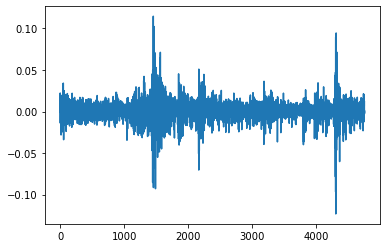

In [37]:
df1['pct_change'].plot()

In [59]:
df1

,Date,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,...,momentum_ppo_signal,momentum_ppo_hist,momentum_kama,others_dr,others_dlr,others_cr,EMA10,EMA100,pct_change,state
0,2003-01-02,489.489990,505.179993,489.489990,505.179993,505.179993,0,0.000000e+00,0,0.000000,...,0.0,0.000000e+00,505.179993,-53.720865,0.000000,0.000000,NaN,NaN,NaN,0.0
1,2003-01-03,505.179993,506.230011,502.100006,504.769989,504.769989,0,0.000000e+00,0,0.000000,...,0.0,0.000000e+00,505.010776,-0.081160,-0.081193,-0.081160,NaN,NaN,-0.000812,0.0
2,2003-01-06,504.769989,517.530029,504.769989,516.039978,516.039978,0,0.000000e+00,0,0.000000,...,0.0,0.000000e+00,509.360835,2.232698,2.208138,2.149726,NaN,NaN,0.022327,-1.0
3,2003-01-07,516.039978,516.650024,510.769989,512.450012,512.450012,0,0.000000e+00,0,0.000000,...,0.0,0.000000e+00,510.634148,-0.695676,-0.698107,1.439095,NaN,NaN,-0.006957,1.0
4,2003-01-08,512.450012,512.450012,504.529999,505.309998,505.309998,0,0.000000e+00,0,0.000000,...,0.0,0.000000e+00,508.391744,-1.393309,-1.403107,0.025734,NaN,NaN,-0.013933,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4749,2021-12-23,2750.840088,2776.620117,2750.840088,2768.360107,2768.360107,0,2.357096e+07,8420800,0.758292,...,-100.0,-2.230536e-08,2723.913013,0.648974,0.646877,447.994803,2730.984040,2676.300265,0.006490,1.0
4750,2021-12-27,2769.340088,2803.879883,2769.340088,2803.739990,2803.739990,0,2.357096e+07,8420800,0.758292,...,-100.0,-2.038367e-08,2725.955470,1.278009,1.269911,454.998225,2744.212394,2678.823824,0.012780,-1.0
4751,2021-12-28,2803.899902,2813.590088,2795.709961,2798.350098,2798.350098,0,2.357096e+07,8420800,0.758292,...,-100.0,-1.862753e-08,2729.177026,-0.192239,-0.192424,453.931299,2754.055613,2681.190680,-0.001922,1.0
4752,2021-12-29,2798.379883,2807.370117,2791.860107,2801.870117,2801.870117,0,2.357096e+07,8420800,0.758292,...,-100.0,-1.702269e-08,2734.793633,0.125789,0.125710,454.628085,2762.749159,2683.580372,0.001258,-1.0


# Output x, y

In [ ]:
# #create dataframe


# #df1["state"]=strat1["state"]

# data2=df1
# data2["state"]=strat2["state"]
# data2.to_csv (r'/Users/muriellai/Desktop/data22.csv', index = False, header=True)

# data3=df1
# data3["state"]=strat3["state"]
# data3.to_csv (r'/Users/muriellai/Desktop/data33.csv', index = False, header=True)


# data4=df1
# data4["state"]=strat5["state"]
# data4.to_csv (r'/Users/muriellai/Desktop/data44.csv', index = False, header=True)



# data5=df1
# data5["state"]=strat6["state"]
# data5.to_csv (r'/Users/muriellai/Desktop/data55.csv', index = False, header=True)


